#SHL_load_dataset.ipynb
This data set loader is for the The University of Sussex-Huawei Locomotion (SHL) dataset. Per the website "a versatile annotated dataset for multimodal locomotion analytics of mobile users."  If you use this dataset please cite using the authors instructions on the website.  http://www.shl-dataset.org/


It will perform a train/test (and optional validation) split and one-hot encode the activity labels.   Returns x/y_train and x/y_test numpy arrays that may be fed directly into a neural net model.

Example usage:

    x_train, y_train, x_test, y_test = shl_load_dataset()
  

Developed and tested using colab.research.google.com

To save as .py version use File > Download .py

More dev notes:
* This version makes hard coded decisions with a goal to get up and running with a reasonable training time.   Specifically, only the acceleration data from the hip motion is used, None of this is parameterized but I tried to make it obvious in the code.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODOs:
* The ability to use saved IR1s needs to be flushed out, especially for the .py version.   In order to run experiments I've only tested the current .py (saved with _temp) while using saved files.
* Lot of parameterization needed to be more flexible.  Goal right now is to get a solid set of arrays with portability in the code.   Downsampling and conversion to smaller dtypes (float32 for X and int8 for y, sub)
* The log_info metadata dictionary needs to be beefed up.




In [1]:
my_dir = '.'
verbose = True
interactive = True # for exploring data and functions interactively

In [ ]:
# skip this cell if running interactive, automatically runs for .py version
interactive = False
verbose = False

In [2]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import requests #for downloading zip file
import numpy as np
import pandas as pd
from tabulate import tabulate # for verbose tables, showing data
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import date
import gc # trying to resolve high memory useage


In [3]:
# Latest copied from SHL loader, avoids issues with !wget as .py file
# Trying to make generic to eventually move to utils notebook.
# TODO: return info_dict when called as util function.
# credit https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
# many other methods I tried failed to download the file properly
def get_url_file(url, fname, chunk_size=1024*1024):
    """checks for existing copy, if not found downloads zip file from web archive
       saves and unzips into my_dir (global - defaults to '.')
       url is file internet location including .zip filename
       fname is the local file name, will be appended to my_dir
       chunk_size passed to requests as 1024*1024 (1MB) lower if memory is a problem"""
    ffname = os.path.join(my_dir,fname)
    if (not os.path.isfile(ffname)):
        print("Downloading", url)
        r = requests.get(url, stream=True)
        with open(ffname, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)
        #info_dict['info_text'] += "\ndataset downloaded from " + url + '\n'
    else:
        print("File", ffname, "found, skipping download")
if (interactive):
    get_url_file(
        url='http://www.shl-dataset.org/wp-content/uploads/SHLDataset_preview_v1_part1.zip',
        fname = 'SHLDataset_preview_v1_part1.zip')

In [4]:
def unzip_shl(
    zip_fname # file name of original dataset zipfile
    ):
    zip_ffname = os.path.join(my_dir,zip_fname)
    """check for local copy, if none unzips the dataset structure in my_dir
    Note most zipfiles include other directories, if the file is zipped flat
    this may need to be changed to a sub directory
    TODO - figure out elegant & generic way to detect if already unzipped"""
    print("Unzipping source file - this takes several minutes")
    if (os.path.exists(zip_ffname)):
        print("Using source file", zip_ffname)
        shutil.unpack_archive(zip_ffname, my_dir, 'zip')
    else:
        print("Error: ", zip_ffname, " not found, exiting")
        return
if interactive:
    unzip_shl('SHLDataset_preview_v1_part1.zip')

Unzipping source file - this takes several minutes
Using source file ./SHLDataset_preview_v1_part1.zip


In [5]:
# Motion and label column names from from doc_dataset.pdf section 3.2
# The first column is Time in ms and is used as the index
def get_column_names():
    """Returns motion and label column names in two lists"""
    motion_columns = [  'Time',
                        'Acceleration X [m/s2]',
                        'Acceleration Y [m/s2]',
                        'Acceleration Z [m/s2]',
                        'Gyroscope X [rad/s]',
                        'Gyroscope Y [rad/s]',
                        'Gyroscope Z [rad/s]',
                        'Magnetometer X [μT]',
                        'Magnetometer Y [μT]',
                        'Magnetometer Z [μT]',
                        'Orientation w',
                        'Orientation x',
                        'Orientation y',
                        'Orientation z',
                        'Gravity X [m/s2]',
                        'Gravity Y [m/s2]',
                        'Gravity Z [m/s2]',
                        'Linear acceleration X [m/s2]',
                        'Linear acceleration Y [m/s2]',
                        'Linear acceleration Z [m/s2]',
                        'Pressure',
                        'Altitude',
                        'Temperature']
    label_columns = ['Time','Coarse label','Fine label','Road label',
                    'Traffic label', 'Tunnels label','Social label','Food label']
    return motion_columns, label_columns
# Coarse Labels Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8 
# t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']

In [6]:
def get_ir1_from_shl_source(
    src_dir = 'undefined', # the directory of the source files
    sub_num = 1 # this is based on the directory, must be passed
    ): 
    """processes the Hips_Motion.txt and Label.txt SHL source files and adds the
    subject number into a returned pandas dataframe in IR1 format"""
    motion_columns, label_columns = get_column_names()
    ffnameX = os.path.join(src_dir,'Hips_Motion.txt')
    ffnamey = os.path.join(src_dir,'Label.txt')
    print("Processing Hip Motion and Labels in", src_dir, "subject number", sub_num)
    df = pd.read_csv(ffnameX, delim_whitespace=True, index_col = False, header=0, names = motion_columns)
    # whitespace is because the text files are space delimited not comma delimited.
    # setting index_col to False means the time will come in as a column and is
    # easier to fix.
    # this is drove me crazy, the time after conversion is off by several
    # hundred nanoseconds. 08:33:18.009999872 orginally was 18.010 ms
    # this screws up the indexing, convert to int before conversion!!! 
    df = df.astype({'Time': 'int64'}) # change future index from float64 to int64
    df['Time'] = pd.to_datetime(df['Time'], unit= 'ms') # convert to datetime
    df.set_index('Time', drop = True, inplace = True)
    drop_columns = motion_columns.copy() # get full column list
    # remove the columns to *keep* - not the ones to be dropped
    drop_columns.remove('Time')
    drop_columns.remove('Acceleration X [m/s2]')
    drop_columns.remove('Acceleration Y [m/s2]')
    drop_columns.remove('Acceleration Z [m/s2]')
    df.drop(drop_columns, axis = 1, inplace = True)
    # calculate total accel - length of accel vector minus 1g (gravity)
    df_sqd = df.pow(2)[['Acceleration X [m/s2]','Acceleration Y [m/s2]','Acceleration Z [m/s2]']] #square each accel
    df_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-9.8  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    # the input data has been processed, now build dataframe from labels
    dfy = pd.read_csv(ffnamey, delim_whitespace=True, index_col = False, header=0, names = label_columns)
    #dfy = dfy[['Time','Coarse label']] # drop all but coarse label, has warning
    dfy = dfy.loc[:,('Time','Coarse label')] # better way per pandas docs
    dfy['Time'] = pd.to_datetime(dfy['Time'], unit= 'ms') # convert to datetime
    dfy.set_index('Time', drop = True, inplace = True)
    # combine the two by indices
    df = df.join(dfy) # join based on time index
    df.rename({"Coarse label": "label"}, axis="columns", inplace = True) # for consistency
    df['sub'] = sub_num # add column with subject number
    # check for gaps in time, if dataframe has gaps resample and sliding window
    # operations may generate erroneous results.
    # ack https://stackoverflow.com/questions/42554704/how-to-spot-gaps-between-pandas-dataframe-indexes
    num_gaps = sum(df.index.to_series().diff() > pd.Timedelta('00:00:00.010'))
    if (num_gaps > 0):
        print('WARNING: Found',num_gaps,'in dataframe, time should be contiguous')
    return df
if (interactive):
    my_df = get_ir1_from_shl_source(os.path.join(my_dir,'SHLDataset_preview_v1/User1/220617'))
    # intial values are NaN, so not very interesting.  Use iloc to skip ahead.
    display(my_df.iloc[10000:10005,:]) # for format to show in Jupyter notebook

Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/220617 subject number 1


,Acceleration X [m/s2],Acceleration Y [m/s2],Acceleration Z [m/s2],accel_ttl,label,sub
Time,,,,,,
2017-06-22 08:33:18.010,-0.268151,0.025036,9.927455,0.131107,0,1
2017-06-22 08:33:18.020,-0.269407,0.010834,9.936565,0.140222,0,1
2017-06-22 08:33:18.030,-0.262285,0.036152,9.946591,0.150114,0,1
2017-06-22 08:33:18.040,-0.268151,0.025018,9.923723,0.127377,0,1
2017-06-22 08:33:18.050,-0.268151,0.008341,9.924507,0.128132,0,1


In [7]:
def resample_ir1(df, new_time_step='50ms'):
    # modified version of to_fixed_timedelta in MobiAct
    """resamples an IR1 DateTime indexed dataframe to new_time_step.  Will
    return NaN per resample method (happens on irregular samples)"""
    if verbose:
        print("Resampling",new_time_step,": Original #rows = ",len(df.index))
    df = df.resample(new_time_step).mean()
    df = df.interpolate() #linear interpolation for nan
    if verbose:
        print("Resampled: New #rows = ",len(df.index))
    return df
if (interactive):
    print(my_df.head())
    my_df = resample_ir1(my_df)
    # intial values are NaN, so not very interesting.  Use iloc to skip ahead.
    #display(my_df.iloc[10000:10005,:]) # for format to show in Jupyter notebook
    print(my_df.head())

                         Acceleration X [m/s2]  Acceleration Y [m/s2]  \
Time                                                                    
2017-06-22 08:31:38.010                    NaN                    NaN   
2017-06-22 08:31:38.020                    NaN                    NaN   
2017-06-22 08:31:38.030                    NaN                    NaN   
2017-06-22 08:31:38.040                    NaN                    NaN   
2017-06-22 08:31:38.050                    NaN                    NaN   

                         Acceleration Z [m/s2]  accel_ttl  label  sub  
Time                                                                   
2017-06-22 08:31:38.010                    NaN       -9.8      0    1  
2017-06-22 08:31:38.020                    NaN       -9.8      0    1  
2017-06-22 08:31:38.030                    NaN       -9.8      0    1  
2017-06-22 08:31:38.040                    NaN       -9.8      0    1  
2017-06-22 08:31:38.050                    NaN       -9.

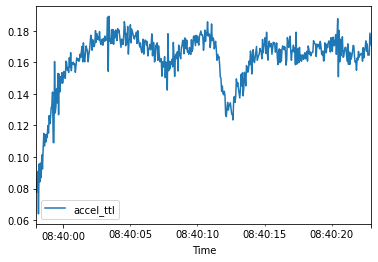

In [8]:
if interactive:
    my_df.iloc[10000:10500].plot(y='accel_ttl') # 5 seconds of total accel

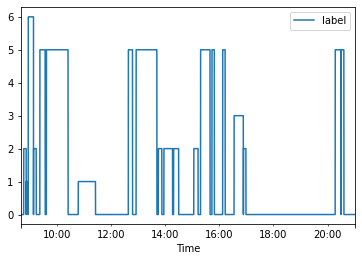

In [9]:
if interactive:
    my_df.iloc[10000:900000].plot(y='label')

In [10]:
def get_ir2_from_ir1(df, time_steps, stride):
    """slice the IR1 dataframe into sliding window segments of
    time_steps length and return X, y, sub ndarrays.
    If stride = time_steps there is no overlap of the sliding window.
    This version does not use append, better for RAM
    df: pandas datetime indexed dataframe columns - channel(s), label, sub
    time_steps: number of samples in window, will discard a partial final window
    stride:  how far to move window, no overlap if equal to time_steps.
    """    
    channel_list = list(df.columns)
    channel_list.remove('label') # need to make sure this is defined for IR1
    channel_list.remove('sub') # ditto - should probably add a check
    if verbose:
        print('Channels in X:',channel_list)
    X = df[channel_list].to_numpy(dtype = 'float32')
    y = df['label'].to_numpy(dtype = 'int8')
    sub = df['sub'].to_numpy(dtype = 'int8')
    if verbose:
        print('X,y,sub array shapes before sliding window', X.shape, y.shape, sub.shape)
    #https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
    shapex = (time_steps,X.shape[1]) # samples (rows to include) and n-dim of original (all channels)
    shapey = (time_steps,) # samples (rows to include) and only one column
    shapesub = (time_steps,) # samples (rows to include) and only one column
    X = np.lib.stride_tricks.sliding_window_view(X, shapex)[::stride, :]
    X = X[:,0,:,:] # I admit I don't understand why this dimension appears...
    y = np.lib.stride_tricks.sliding_window_view(y, shapey)[::stride, :]
    sub = np.lib.stride_tricks.sliding_window_view(sub, shapesub)[::stride, :]
    if verbose:
        print('X,y,sub array shapes after sliding window', X.shape, y.shape, sub.shape)
    return X, y, sub
if interactive:
    my_X, my_y, my_sub = get_ir2_from_ir1(my_df, 500, 500)

Channels in X: ['Acceleration X [m/s2]', 'Acceleration Y [m/s2]', 'Acceleration Z [m/s2]', 'accel_ttl']
X,y,sub array shapes before sliding window (928961, 4) (928961,) (928961,)
X,y,sub array shapes after sliding window (1857, 500, 4) (1857, 500) (1857, 500)


In [11]:
def clean_ir2(X, y, sub):
    """removes sliding windows containing NaN, multiple labels, or multiple
    subject numbers.  Collapses y, sub to column arrays.
    Returns cleaned version of X, y, sub"""
    # Check for NaN
    nans = np.argwhere(np.isnan(X))
    num_nans = np.unique(nans[:,0]) #[:,0] accesses just 1st column
    if verbose:
        print(num_nans.shape[0], "NaN entries found, removing")
    idx = ~np.isnan(X).any(axis=2).any(axis=1)
    # this warrants some explanation!
    # any(axis=1) and 2 collapses channels and samples
    # good axis explanation https://www.sharpsightlabs.com/blog/numpy-axes-explained/
    # the ~ negates so NaN location are now False in the idx which is then
    # used to filter out the bad windows below
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    # repeat and confirm NaNs have been removed
    nans = np.argwhere(np.isnan(X))
    num_nans = np.unique(nans[:,0]) #[:,0] accesses just 1st column
    if (nans.size!=0):
        print("WARNING! Cleaned output arrays still contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    # Now get rid of segments with multiple labels
    # Not happy with this code, must be a better way but it seems to work...
    idx = []
    for i in range(y.shape[0]):
        if np.all(y[i] == y[i][0]):
            idx.append(True)
            
        else:
            idx.append(False)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    # TODO check for multiple subjects in window
    y = y[:,0] # collapse columns
    y = y[np.newaxis].T  # convert to single column array
    sub = sub[:,0] # repeat for sub array
    sub = sub[np.newaxis].T
    return X, y, sub
if interactive:
    my_X, my_y, my_sub = clean_ir2(my_X, my_y, my_sub)
    print('X, y, sub array shapes after sliding window', my_X.shape, my_y.shape, my_sub.shape)

1 NaN entries found, removing
X, y, sub array shapes after sliding window (1818, 500, 4) (1818, 1) (1818, 1)


In [12]:
def drop_label_ir2_ir3(X, y, sub, label_to_drop):
    """removes windows with label = label_to_drop
    Returns updated version of X, y, sub"""
    idx = []
    for i in range(y.shape[0]):
        if (y[i] == label_to_drop):
            idx.append(False)
        else:
            idx.append(True)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    return X, y, sub
if interactive:
    print("Label counts before drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('X, y, sub array shapes before label drop', my_X.shape, my_y.shape, my_sub.shape)
    my_X, my_y, my_sub = drop_label_ir2_ir3(my_X, my_y, my_sub, 0)
    print("Label counts after drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('X, y, sub array shapes after label drop', my_X.shape, my_y.shape, my_sub.shape)

Label counts before drop
[[   0 1109]
 [   1   98]
 [   2  148]
 [   3   49]
 [   5  387]
 [   6   27]]
X, y, sub array shapes before label drop (1818, 500, 4) (1818, 1) (1818, 1)
Label counts after drop
[[  1  98]
 [  2 148]
 [  3  49]
 [  5 387]
 [  6  27]]
X, y, sub array shapes after label drop (709, 500, 4) (709, 1) (709, 1)


In [13]:
verbose = False

In [16]:
def stack_ir2_into_ir3():
    """Uses pipeline to build individual IR1 (dataframes) and IR2 (ndarrays)
    for the SHL dataset.  Stacks the IR2 arrays into an IR3 which consists
    of X (channel data), y (labels), sub (subject numbers)"""
    log_info = "Generated by SHL_load_dataset\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    url_list = ['http://www.shl-dataset.org/wp-content/uploads/SHLDataset_preview_v1_part1.zip',
        'http://www.shl-dataset.org/wp-content/uploads/SHLDataset_preview_v1_part2.zip',
        'http://www.shl-dataset.org/wp-content/uploads/SHLDataset_preview_v1_part3.zip']
    for index, url in enumerate(url_list):
        fname = url.split("/")[-1] # last element after split on /
        get_url_file(url,fname)
        log_info += 'Downloaded '+str(url)+"\n"  
        # crude check to see if already unzipped
        test_dir = os.path.join(my_dir,'SHLDataset_preview_v1',('User'+ str(index+1)))
        if (os.path.exists(test_dir)):
            print('Directory', test_dir, 'found.  Skipping unzip')
        else:
            unzip_shl(fname)
    # source files setup, now go into each dir and process
    # raw data to IR1 (df) then IR2 (np) then IR3 (stacked IR2s)
    # this is hard-coded and uses DRAM hogging append, fingers crossed...
    X3 = np.zeros(shape=(1,100,4)) # need to fix this so not hardcoded!
    y3 = np.zeros(shape=(1,1), dtype='int') # unicode 10 char
    sub3 = np.zeros(shape=(1,1),dtype='int') # one subject number per entry
    src_list = [['220617','260617','270617'],
                ['140617','140717','180717'],
                ['030717','070717','140617']]
    for index, dir_nums in enumerate(src_list):
        for index2, num in enumerate(dir_nums):
            src_dir = os.path.join(my_dir,'SHLDataset_preview_v1',
                            ('User'+ str(index+1)),num)
            if (os.path.exists(src_dir)):
                sub_num = index + 1
                df_ir1 = get_ir1_from_shl_source(src_dir,sub_num)
                df_ir1 = resample_ir1(df_ir1,new_time_step='50ms') # resample to 20Hz
                X2, y2, sub2 = get_ir2_from_ir1(df_ir1, time_steps = 100, stride = 100)
                X2, y2, sub2 = clean_ir2(X2, y2, sub2)
                X2, y2, sub2 = drop_label_ir2_ir3(X2, y2, sub2, 0) # drop null
                if verbose:
                    print('X,y,sub array shapes dropping NaN and null labels', X2.shape, y2.shape, sub2.shape)
                X3 = np.vstack([X3, X2])
                y3 = np.vstack([y3, y2])
                sub3 = np.vstack([sub3, sub2])
            else:
                print('Something went wrong',src_dir,'not found')
                return
    #delete first row placeholders
    X3 = np.delete(X3, (0), axis=0) 
    y3 = np.delete(y3, (0), axis=0) 
    sub3 = np.delete(sub3, (0), axis=0)
    # reduce dtype size
    X3 = X3.astype('float32')
    y3 = y3.astype('int8')
    sub3 = sub3.astype('int8')
    return X3, y3, sub3
if (interactive):
    my_X, my_y, my_sub = stack_ir2_into_ir3()
    print('Final X, y, sub array shapes', my_X.shape, my_y.shape, my_sub.shape)
    headers = ("Reshaped data","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print(tabulate(mydata, headers=headers))

File ./SHLDataset_preview_v1_part1.zip found, skipping download
Directory ./SHLDataset_preview_v1/User1 found.  Skipping unzip
File ./SHLDataset_preview_v1_part2.zip found, skipping download
Directory ./SHLDataset_preview_v1/User2 found.  Skipping unzip
File ./SHLDataset_preview_v1_part3.zip found, skipping download
Directory ./SHLDataset_preview_v1/User3 found.  Skipping unzip
Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/220617 subject number 1
Channels in X: ['Acceleration X [m/s2]', 'Acceleration Y [m/s2]', 'Acceleration Z [m/s2]', 'accel_ttl']
Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/260617 subject number 1
Channels in X: ['Acceleration X [m/s2]', 'Acceleration Y [m/s2]', 'Acceleration Z [m/s2]', 'accel_ttl']
Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/270617 subject number 1
Channels in X: ['Acceleration X [m/s2]', 'Acceleration Y [m/s2]', 'Acceleration Z [m/s2]', 'accel_ttl']
Processing Hip Motion and Labels in .

In [16]:
if False: #change to true to save X, y, sub numpy files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/shl/ir3_20hz'
    xys_info = 'xys_info not implemented'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/X.npy')):
            summary = "SHL early version\n"
            summary += "Saved to " + output_dir + "\n"
            summary = "This version downsampled to 20Hz\n"
            summary += "Generated by SHL_load_dataset.ipynb" 
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

            info_fname = output_dir +'/'+'info.txt'
            full_info = summary + "\n" + xys_info + "\n"
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)

            if True:
                np.save(output_dir + '/'+'X.npy',my_X)
                np.save(output_dir + '/'+'y.npy',my_y)
                np.save(output_dir + '/'+'sub.npy',my_sub)
        else:
            print("Error "+output_dir+" contains X.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

In [17]:
def shl_load_dataset(
    use_saved_xysub = True, # get X,y,sub from zip, True = faster to used saved ones
    incl_val_group = False, # split train into train and validate
    split_subj = dict
                (train_subj = [1],
                validation_subj = [2],
                test_subj = [3]),
    one_hot_encode = True, # make y into multi-column one-hot, one for each activity
    return_info_dict = False # return dict of meta info along with ndarrays
    ):
    
    """Downloads The University of Sussex-Huawei Locomotion and Transportation
    Dataset (SHL), processes each sessions data into a Pandas Dataframe Intermediate
    Representation (IR1)  returned arrays by separating
    into _train, _validate, and _test arrays for X and y based on split_sub
    dictionary."""
    print("shl_load_dataset: use_saved_xysub =", use_saved_xysub)
    log_info = "Generated by SHL_load_dataset\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    log_info += "sub dict = " + str(split_subj) + "\n"
    if (not use_saved_xysub):
        X, y, sub = stack_ir2_into_ir3()
    else:
        # read previously stored X, y, sub arrays instead of creating from zip
        # saves time when running multiple train/test split experiments
        # e.g. passing different subject dictionaries to this method
        # create & save X, y, sub using Leotta_2021_get_X_y_sub.ipynb interactively
        input_dir = '/content/drive/MyDrive/Processed_Datasets/shl/ir3_20hz'
        X = np.load(input_dir + '/'+'X.npy')
        y = np.load(input_dir + '/'+'y.npy')
        sub = np.load(input_dir + '/'+'sub.npy')
        log_info += "X, y, sub loaded from "+str(input_dir)+"\n"
    # write initial array info to log_info
    headers = ("Initial Array","shape", "object type", "data type")
    mydata = [("X", X.shape, type(X), X.dtype),
              ("y", y.shape, type(y), y.dtype),
              ("sub", sub.shape, type(sub), sub.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers) + "\n"
    #remove component accel if needed <deleted - need to implement drop columns>
 
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if (verbose):
            print("One-hot-encoding: category names -> int -> one-hot \n")
            print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        #print("One-hot-encoding",onehot_encoder.categories_)
        y=onehot_encoded
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
        x_train = X[train_index]
        y_train = y[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = X[train_index]
        y_train = y[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['validation_subj']))
        x_validation = X[validation_index]
        y_validation = y[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]

    headers = ("Returned Array","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype)]
    if (incl_val_group):
        mydata += [("x_validation:", x_validation.shape, type(x_validation), x_validation.dtype),
                        ("y_validation:", y_validation.shape ,type(y_validation), y_validation.dtype)]
    mydata += [("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers)
    if (incl_val_group):
        if (return_info_dict):
            return x_train, y_train, x_validation, y_validation, x_test, y_test, log_info
        else:
            return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        if (return_info_dict):
            return x_train, y_train, x_test, y_test, log_info
        else:
            return x_train, y_train, x_test, y_test


In [19]:
if __name__ == "__main__":
    print("Without saved IR3 (X, y ,sub) this will take an hour+ to run")
    x_train, y_train, x_test, y_test \
                             = shl_load_dataset(use_saved_xysub = False, 
                                                return_info_dict = False)
    print("\nreturned arrays without validation group:")
    headers = ("Reshaped data","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
            ("y_train:", y_train.shape ,type(y_train), y_train.dtype),
            ("x_test:", x_test.shape, type(x_test), x_test.dtype),
            ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    print(tabulate(mydata, headers=headers))
    print("\n----------- Contents of returned log_info ---------------")
    #print(log_info)
    print("Without saved IR3 (X, y ,sub) this will take an hour+ to run")
    x_train, y_train, x_valid, y_valid, x_test, y_test \
                             = shl_load_dataset(use_saved_xysub = False,
                                                incl_val_group = True, 
                                                return_info_dict = False)
    print("\nreturned arrays with validation group:")
    headers = ("Reshaped data","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
            ("y_train:", y_train.shape ,type(y_train), y_train.dtype),
            ("x_valid:", x_valid.shape, type(x_valid), x_valid.dtype),
            ("y_valid:", y_valid.shape ,type(y_valid), y_valid.dtype),
            ("x_test:", x_test.shape, type(x_test), x_test.dtype),
            ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    print(tabulate(mydata, headers=headers))

Without saved IR3 (X, y ,sub) this will take an hour+ to run
shl_load_dataset: use_saved_xysub = False
File ./SHLDataset_preview_v1_part1.zip found, skipping download
Directory ./SHLDataset_preview_v1/User1 found.  Skipping unzip
File ./SHLDataset_preview_v1_part2.zip found, skipping download
Directory ./SHLDataset_preview_v1/User2 found.  Skipping unzip
File ./SHLDataset_preview_v1_part3.zip found, skipping download
Directory ./SHLDataset_preview_v1/User3 found.  Skipping unzip
Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/220617 subject number 1
Channels in X: ['Acceleration X [m/s2]', 'Acceleration Y [m/s2]', 'Acceleration Z [m/s2]', 'accel_ttl']
Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/260617 subject number 1
Channels in X: ['Acceleration X [m/s2]', 'Acceleration Y [m/s2]', 'Acceleration Z [m/s2]', 'accel_ttl']
Processing Hip Motion and Labels in ./SHLDataset_preview_v1/User1/270617 subject number 1
Channels in X: ['Acceleration X [m/s2]

In [ ]:
if False: #change to true to save final numpy files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/shl/train_test_20hz'
    xys_info = 'xys_info not implemented'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/x_train.npy')):
            summary = "SHL early version for AAAI work\n"
            summary += "Saved to " + output_dir + "\n"
            summary = "This version downsampled to 20Hz\n"
            summary += "Generated by SHL_load_dataset.ipynb" 
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

            info_fname = output_dir +'/'+'info.txt'
            full_info = summary + "\n" + xys_info + "\n"
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)

            if True:
                np.save(output_dir + '/'+'x_train.npy',x_train)
                np.save(output_dir + '/'+'x_test.npy',x_test)
                np.save(output_dir + '/'+'y_train.npy',y_train)
                np.save(output_dir + '/'+'y_test.npy',y_test)
        else:
            print("Error "+output_dir+" contains X.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 